# Tester fra getting_started og 6_ex_post

In [363]:
import pandas as pd 
import numpy as np 
import numpy.linalg as la
from sklearn.linear_model import Lasso
from scipy.stats import norm
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import labels
import geopandas

In [328]:
dat = pd.read_csv('growth.csv')
lbldf = pd.read_csv('labels.csv', index_col='variable')
lbl_all = lbldf.label.to_dict() # as a dictionary
print(f'The data contains {dat.shape[0]} rows (countries) and {dat.shape[1]} columns (variables).')

The data contains 214 rows (countries) and 85 columns (variables).


# Variable selection

In [329]:
# all available variables

#  'marketref', 
#  , 
vv_regressors = ['lgdp_initial', 'pop_growth', 'investment_rate']
vv_institutions = ['dem', 'demCGV', 'demBMR', 'demreg'] 
vv_geography = [
        'tropicar','distr', 'distcr', 'distc','suitavg','temp', 'suitgini', 'elevavg', 'elevstd',
        'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough','landlock', 
        'africa',  'asia', 'oceania', 'americas' # 'europe' is the reference
]
vv_geneticdiversity = ['pdiv', 'pdiv_aa'] #, 'pdivhmi', 'pdivhmi_aa']
vv_historical = ['pd1000', 'pd1500', 'pop1000', 'pop1500', 'ln_yst'] # these are often missing: ['pd1', 'pop1']
vv_religion = ['pprotest', 'pcatholic', 'pmuslim']
vv_danger = ['yellow', 'malfal',  'uvdamage']
vv_resources = ['oilres', 'goldm', 'iron', 'silv', 'zinc']
vv_educ = ['ls_bl', 'lh_bl'] # secondary, tertiary: we exclude 'lp_bl' (primary) to avoid rank failure 

vv_all = {'regressors': vv_regressors,
          'institutions': vv_institutions, 
          'geography': vv_geography, 
          'geneticdiversity': vv_geneticdiversity,
          'historical': vv_historical,
          'religion': vv_religion,
          'danger':vv_danger, 
          'resources':vv_resources,
          'education':vv_educ
         }
list_of_lists = vv_all.values()
vv_all['all'] = [v for sublist in list_of_lists for v in sublist]

#print([item for item in variables if item not in vv_all['all']])

list_of_var = vv_regressors + vv_institutions + vv_geography + vv_geneticdiversity + vv_historical + vv_religion + vv_danger + vv_resources + vv_educ


In [389]:
vs = vv_all['all'] #+ ['code']
xs = vs

# avoiding missings
all_vars = ['gdp_growth'] + xs
I = dat[all_vars].notnull().all(1)

# extract data
X_basic = dat.loc[I, xs].values
y = dat.loc[I,'gdp_growth'].values.reshape((-1,1)) * 100. #easier to read output when growth is in 100%
# add const. (unless this breaks the rank condition)
# oo = np.ones((I.sum(),1))
# X = np.hstack([X, oo])
# xs.append('constant') # we put it in as the last element

# check the rank condition
#K = X.shape[1]
#assert np.linalg.matrix_rank(X) == X.shape[1], f'X does not have full rank'

# compute the OLS estimator
#betas = np.linalg.inv(X.T @ X) @ X.T @ y

## Tables to appendix

In [369]:
# MAKING A TABLE OF USED VARIABLES: Filter the DataFrame based on values in Column1
selected_rows = lbldf.loc[lbldf.index.isin(list_of_var)]

In [388]:
lande_test = pd.DataFrame(X_basic, columns=xs)
lande_test = lande_test.set_index('code')
lande_test

pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)     # Show all rows

lande_test

lande = lande_test.index

countries = ['ARG', 'AUS', 'AUT', 'BDI', 'BEL', 'BEN', 'BOL', 'BRA', 'BWA', 'CAF',
             'CHL', 'CHN', 'CIV', 'CMR', 'COG', 'COL', 'CRI', 'DEU', 'DNK', 'DOM',
             'DZA', 'ECU', 'EGY', 'ESP', 'FRA', 'GAB', 'GBR', 'GHA', 'GMB', 'GRC',
             'GTM', 'HND', 'HTI', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ITA', 'KEN',
             'KOR', 'LKA', 'LSO', 'MAR', 'MEX', 'MLI', 'MMR', 'MRT', 'MYS', 'NER',
             'NIC', 'NLD', 'NOR', 'NPL', 'PAK', 'PAN', 'PER', 'PHL', 'PRT', 'PRY',
             'RWA', 'SAU', 'SDN', 'SEN', 'SLE', 'SLV', 'SWE', 'TGO', 'THA', 'TUN',
             'TUR', 'USA', 'ZAF', 'ZMB', 'ZWE']

# Convert the list to a Pandas Series
series = pd.Series(countries)

# Format the Series as a LaTeX table
#latex_table = series.to_latex(index=False, header=False)

# Print the LaTeX table
#print(latex_table)

#countries_included = pd.DataFrame(lande_test['code'])

## Calculating missings for earch variable

In [392]:
for v, k in vv_all.items():
    print(f'Group {v} has variables {k}')
    for i in k:
        num_missing = dat[i].isnull().sum()
        print(f'Variable {i} has {num_missing} missing values')

Group regressors has variables ['lgdp_initial', 'pop_growth', 'investment_rate']
Variable lgdp_initial has 105 missing values
Variable pop_growth has 16 missing values
Variable investment_rate has 35 missing values
Group institutions has variables ['dem', 'demCGV', 'demBMR', 'demreg']
Variable dem has 59 missing values
Variable demCGV has 64 missing values
Variable demBMR has 60 missing values
Variable demreg has 31 missing values
Group geography has variables ['tropicar', 'distr', 'distcr', 'distc', 'suitavg', 'temp', 'suitgini', 'elevavg', 'elevstd', 'kgatr', 'precip', 'area', 'abslat', 'cenlong', 'area_ar', 'rough', 'landlock', 'africa', 'asia', 'oceania', 'americas']
Variable tropicar has 55 missing values
Variable distr has 55 missing values
Variable distcr has 55 missing values
Variable distc has 55 missing values
Variable suitavg has 59 missing values
Variable temp has 30 missing values
Variable suitgini has 54 missing values
Variable elevavg has 30 missing values
Variable elevs

# Poulynomial features d, and controls

In [393]:
d = X_basic[:, 0].reshape(-1,1)

Z_basic = X_basic[:, 1:]


poly = PolynomialFeatures(3, include_bias=False)
Z = poly.fit_transform(Z_basic)

#X = X_basic

# Find constant columns using NumPy
constant_columns = np.all(Z == Z[0, :], axis=0)

# Remove constant columns
Z_nocons = Z[:, ~constant_columns]


In [394]:
X = np.column_stack((d,Z))

print(X_basic.shape)
print(d.shape)
print(Z_basic.shape)
print(Z.shape)
print(Z_nocons.shape)

(75, 48)
(75, 1)
(75, 47)
(75, 19599)
(75, 18871)


## Standardize

In [409]:
def standardize(X):
    X_mean = np.mean(X,axis=0)
    X_std = np.std(X,axis=0, ddof=1)
    X_stan=(X-X_mean)/X_std
    return X_stan

# Standardize data
X_stan = standardize(X_nocons)
d_stan = standardize(d)
Z_stan = standardize(Z_nocons)

print(Z_stan.shape)

(75, 18871)


## BCCH - Choosing lambda - Lasso

In [410]:
# BCCH

def BCCH_pen(X_stan, y):

    n,p = X_stan.shape
    c = 1.1
    alpha = 0.05

    yXscale = (np.max((X_stan.T ** 2) @ ((y-np.mean(y)) ** 2) / n)) ** 0.5
    penalty_pilot = c / np.sqrt(n) * norm.ppf(1-alpha/(2*p)) * yXscale # Note: Have divided by 2 due to Python definition of Lasso
    print('Penalty_pilot: ', round(penalty_pilot, 2))

    # Pilot estimates
    #Create predicted value using Lasso
    pred = Lasso(alpha=penalty_pilot).fit(X_stan,y).predict(X_stan).reshape(-1,1)

    # Alternative: Manually
    # coeff_pilot = Lasso(alpha=penalty_pilot).fit(X_stan,y).coef_
    # coef_intercept = Lasso(alpha=penalty_pilot).fit(X_stan,y).intercept_
    # pred = (coef_intercept + X_stan@coeff_pilot)

    # Updated penalty
    eps = y - pred
    epsXscale = (np.max((X_stan.T ** 2) @ (eps ** 2) / n)) ** 0.5
    penalty_BCCH = c*norm.ppf(1-alpha/(2*p))*epsXscale/np.sqrt(n)
    print('Penalty BCCH: ', round(penalty_BCCH, 2))

    # Updated estimates
    fit_BCCH = Lasso(alpha=penalty_BCCH).fit(X_stan,y)
    coeff_BCCH = fit_BCCH.coef_
    print('Coefficients: ', np.round(coeff_BCCH))

    # Selected variables
    selected_variables_BCCH = (coeff_BCCH != 0)
    #print('Selected varriables: ', Xnames[selected_variables_BCCH].to_list())
    
    return penalty_BCCH

In [411]:
n,p = X_stan.shape
c = 1.1
alpha = 0.05

yXscale = (np.max((X_stan.T ** 2) @ ((y-np.mean(y)) ** 2) / n)) ** 0.5
penalty_pilot = c / np.sqrt(n) * norm.ppf(1-alpha/(2*p)) * yXscale # Note: Have divided by 2 due to Python definition of Lasso
print('Penalty_pilot: ', round(penalty_pilot, 2))

# Pilot estimates
#Create predicted value using Lasso
pred = Lasso(alpha=penalty_pilot).fit(X_stan,y).predict(X_stan).reshape(-1,1)

# Alternative: Manually
# coeff_pilot = Lasso(alpha=penalty_pilot).fit(X_stan,y).coef_
# coef_intercept = Lasso(alpha=penalty_pilot).fit(X_stan,y).intercept_
# pred = (coef_intercept + X_stan@coeff_pilot)

# Updated penalty
eps = y - pred
epsXscale = (np.max((X_stan.T ** 2) @ (eps ** 2) / n)) ** 0.5
penalty_BCCH = c*norm.ppf(1-alpha/(2*p))*epsXscale/np.sqrt(n)
print('Penalty BCCH: ', round(penalty_BCCH, 2))

# Updated estimates
fit_BCCH = Lasso(alpha=penalty_BCCH).fit(X_stan,y)
coeff_BCCH = fit_BCCH.coef_
print('Coefficients: ', np.round(coeff_BCCH))

# Selected variables
selected_variables_BCCH = (coeff_BCCH != 0)
#print('Selected varriables: ', Xnames[selected_variables_BCCH].to_list())

Penalty_pilot:  3.48
Penalty BCCH:  3.48
Coefficients:  [-0. -0.  0. ...  0.  0.  0.]


## BCCH - PDL

In [412]:
# Calculate residuals
resyx=y-fit_BCCH.predict(X_stan)

# Calculate Y - Z@gamma
resyxz = resyx + d_stan*coeff_BCCH[0]

# Display first coefficient
print("First coefficient =",coeff_BCCH[0].round(2))

First coefficient = -0.0


In [413]:
# Calculate BRT penalty
penalty_BCCHdz = BCCH_pen(Z_stan, d)

# Run Lasso
fit_BCCHdz=Lasso(alpha=penalty_BCCHdz, max_iter=10_000).fit(Z_stan,d) 
coefs=fit_BCCHdz.coef_

# Calculate residuals
resdz=d-fit_BCCHdz.predict(Z_stan)

# Display first coefficient
print("First coefficient =",coefs[0].round(10))

Penalty_pilot:  1.53
Penalty BCCH:  1.53
Coefficients:  [-0.  0.  0. ...  0.  0.  0.]
First coefficient = -0.0


In [414]:
# Calculate alpha
num = np.sum(resdz*resyxz)
denom = np.sum(resdz*d)
beta_PDL = num/denom

# Display alpha
print("beta_PDL = ",beta_PDL.round(5))

beta_PDL =  -0.16573


In [415]:
# Calculate variance    
num = np.sum(resyx**2 * resdz**2) / n
denom = (np.sum(resdz**2) / n)**2
sigma2_PDL = num/denom

# Display variance
print("sigma2_PDL = ",sigma2_PDL.round(5))

sigma2_PDL =  0.01821


In [416]:
# Calculate standard error
se_PDL=np.sqrt(sigma2_PDL) /np.sqrt(n)

# Display standard error
print("se_PDL = ",se_PDL.round(5))

se_PDL =  0.01558


## Confidence interval

In [417]:
# Calculate the quantile of the standard normal distribution that corresponds to the 95% confidence interval of a two-sided test
q = norm.ppf(1-0.025)

# Calculate confidence interval
CI_low_PDL  = alpha_PDL - q*se_PDL
CI_high_PDL = alpha_PDL + q*se_PDL

# Display confidence interval
print("CI_PDL = ",(CI_low_PDL.round(3),CI_high_PDL.round(3)))

CI_PDL =  (-0.196, -0.135)


# Test med landkort

In [376]:
kort = pd.DataFrame(X_basic, columns=xs)

/var/folders/2c/dg2kgl611z5c74nvz9fw_x9m0000gp/T/ipykernel_37778/59734491.py:2: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))


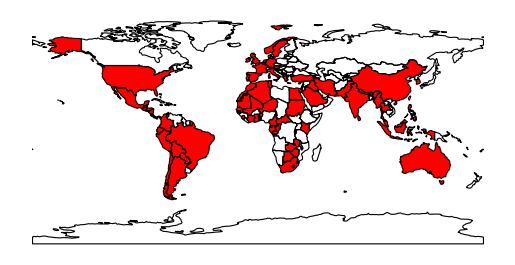

In [405]:
# Load the world map dataset
world = geopandas.read_file(geopandas.datasets.get_path('naturalearth_lowres'))

# List of country codes to highlight
highlighted_countries = ['ARG', 'AUS', 'AUT', 'BDI', 'BEL', 'BEN', 'BOL', 'BRA', 'BWA', 'CAF',
             'CHL', 'CHN', 'CIV', 'CMR', 'COG', 'COL', 'CRI', 'DEU', 'DNK', 'DOM',
             'DZA', 'ECU', 'EGY', 'ESP', 'FRA', 'GAB', 'GBR', 'GHA', 'GMB', 'GRC',
             'GTM', 'HND', 'HTI', 'IDN', 'IND', 'IRL', 'IRN', 'IRQ', 'ITA', 'KEN',
             'KOR', 'LKA', 'LSO', 'MAR', 'MEX', 'MLI', 'MMR', 'MRT', 'MYS', 'NER',
             'NIC', 'NLD', 'NOR', 'NPL', 'PAK', 'PAN', 'PER', 'PHL', 'PRT', 'PRY',
             'RWA', 'SAU', 'SDN', 'SEN', 'SLE', 'SLV', 'SWE', 'TGO', 'THA', 'TUN',
             'TUR', 'USA', 'ZAF', 'ZMB', 'ZWE']

# Filter the world dataset to include only the highlighted countries
highlighted_world = world[world['iso_a3'].isin(highlighted_countries)]

# Plot the world map with highlighted countries
world.boundary.plot(linewidth=0.8, color='k', ax=plt.gca())
highlighted_world.plot(ax=plt.gca(), color='red')

plt.axis('off')

# Set the plot title
#plt.title("Countries included in analysis")

plt.savefig('world_map.pdf', bbox_inches='tight', pad_inches=0.1)

# Show the plot
plt.show()